<a href="https://colab.research.google.com/github/Pavinithan1998/research_Federated_learning/blob/main/Research_FL_Leukemia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enhancing Leukemia Prediction with Federated learning approach for Image classification

In [ ]:
!pip install --quiet --upgrade tensorflow-federated

In [ ]:
!pip install imutils opencv-python scikit-learn matplotlib

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
%load_ext tensorboard

### Import necessary libraries

In [ ]:
import tensorflow_federated as tff
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow_federated import learning
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import re

### Data preprocessing and loading (Images are in "WBC-Benign" and "WBC-Malignant" format)

In [ ]:
def load(paths):
    data = []
    labels = []
    for (i, imgpath) in enumerate(paths):
        image = cv2.imread(imgpath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # Extract the label from the filename
        if "WBC-Benign" in imgpath:
            label = 0  # Healthy
        elif "WBC-Malignant" in imgpath:
            label = 1  # Unhealthy
        else:
            continue  # Skip images with unknown labels

        data.append(image)
        labels.append(label)
    data = np.array(data, dtype="float") / 255.0
    return data, labels

img_path = '/content/drive/MyDrive/research/dataset/Benign'
image_paths = list(paths.list_images(img_path))
image_list, label_list = load(image_paths)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

In [ ]:
label_list

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

#### Split dataset  X_train, X_test, y_train, y_test



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.1)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1340, 224, 224, 3)
X_test shape: (149, 224, 224, 3)
y_train shape: (1340, 1)
y_test shape: (149, 1)


#### Create clients

In [ ]:
def create_clients(image_list, label_list, num_clients=10):
    data_shards = np.array_split(image_list, num_clients)
    label_shards = np.array_split(label_list, num_clients)
    clients = {}
    for i in range(num_clients):
        client_name = f"client_{i+1}"
        clients[client_name] = (data_shards[i], label_shards[i])
    return clients

clients = create_clients(X_train, y_train, num_clients=10)

#### Define a function to create a DenseNet121 model

 In some cases, batch normalization may significantly improve training stability and performance. In other cases, especially in some specialized architectures or transfer learning scenarios, batch normalization might not be used to better suit the specific requirements of the task.

##### **DenseNet121 Without top layers**

In [ ]:
def create_densenet_model():
  """Creates a DenseNet model without batch normalization layers."""
  base_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                                 include_top=False)
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
  return model

# Create a global server model
server_model = create_densenet_model()

29084464/29084464 [==============================] - 1s 0us/step


##### **DenseNet-201 model without the top**

In [ ]:
def create_densenet_201_model():
    input_shape=(224, 224, 3)
    # Load the pre-trained DenseNet-201 model without the top (classification) layer
    base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

    # Adding custom top layer for your specific task
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    return model

# Create a global server model based on DenseNet-201
server_model = create_densenet_201_model()


#### Define a function to create a resNet152 model

In [ ]:
def create_resnet_152_model():
    input_shape=(224, 224, 3)
    # Load the pre-trained ResNet-152 model without the top (classification) layer
    base_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add your custom top layer for your specific task
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    return model

# Create a global server model based on ResNet-152
server_model = create_resnet_152_model()

234698864/234698864 [==============================] - 7s 0us/step


In [ ]:
def create_resnet_50_model():
    input_shape=(224, 224, 3)
    # Load the pre-trained ResNet-50 model without the top (classification) layer
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add your custom top layer for your specific task
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    return model

# Create a global server model based on ResNet-50
server_model = create_resnet_50_model()

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Create a federated computation for server aggregation
@tff.tf_computation
def server_aggregate(model_weights, client_weights, client_sizes):
    weighted_averages = [model_weight * tf.cast(client_size, tf.float32) for model_weight, client_size in zip(client_weights, client_sizes)]
    sum_weights = tf.add_n(weighted_averages)
    return [w / tf.cast(sum_weights, tf.float32) for w in model_weights]

@tff.federated_computation
def federated_averaging(server_model, client_models, client_sizes):
    return tff.federated_map(server_aggregate, (tff.federated_broadcast(server_model), client_models, client_sizes))

In [ ]:
# Import the legacy optimizer
from tensorflow.keras.optimizers.legacy import SGD

In [ ]:
# Federated Learning Loop
lr = 0.01
update_rounds = 5
learning_rate = lr
loss = 'binary_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False)

In [ ]:
import matplotlib.pyplot as plt

# Lists to store accuracy values
rounds = []
accuracies = []
server_losses= []

#### Fedeated Averaging algorithm

In [ ]:
def federated_agerage(local_models):
  # Use federated averaging to aggregate the local models
  aggregated_weights = [model.get_weights() for model in local_models]

  # Calculate the mean of the aggregated weights for each layer
  global_weights = []
  for layer_weights_list in zip(*aggregated_weights):
      # Calculate the mean for each layer's weights
      layer_mean = np.mean(layer_weights_list, axis=0)
      global_weights.append(layer_mean)


  # Set the global model's weights to the aggregated global weights
  server_model.set_weights(global_weights)
  return server_model

###Training process - Simulation for denseNet121

In [ ]:
for update_round in range(update_rounds):
    # Randomize the order of client names for better privacy
    client_names = list(clients.keys())
    random.shuffle(client_names)

    local_models = []

    for client_name in client_names:
        data = clients[client_name]

        # Create a local model for the client
        local_model = create_densenet_model()

        # Compile the local model with the loss, optimizer, and metrics
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        # Set the local model's weights to the current global weights
        local_model.set_weights(server_model.get_weights())

        # Extract data from the federated dataset
        # X_client, y_client = zip(*data)
        # X_client, y_client = np.array(X_client), np.array(y_client)
        X_client, y_client = np.array(data[0]), np.array(data[1])

        # Train the local model on the client's data and the current global model
        local_model.fit(X_client, y_client, epochs=1, batch_size=32)

        local_models.append(local_model)

        # Clear the Keras session to release memory
        K.clear_session()

    # # Use federated averaging to aggregate the local models
    # aggregated_weights = [tf.convert_to_tensor(model.get_weights()) for model in local_models]

    # # Calculate the mean of the aggregated weights
    # global_weights = [tf.reduce_mean(aggregated_weights, axis=0).numpy()]

    # # Set the global model's weights to the aggregated global weights
    # server_model.set_weights(global_weights[0])
    server_model = federated_agerage(local_models)

    # Evaluate the global model
    server_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    global_acc = server_model.evaluate(X_test, y_test, verbose=0)[1]

    # Append accuracy values to the lists
    rounds.append(update_round + 1)
    accuracies.append(global_acc)

    print(f'Update Round: {update_round + 1} | Global Accuracy: {global_acc * 100:.2f}%')


NameError: ignored

#### Test the final global model

In [ ]:
# Test the final global model
final_global_acc = server_model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Final Global Accuracy: {final_global_acc * 100:.2f}%')

Final Global Accuracy: 76.51%


#### Plot the global model accuracy values through epochs

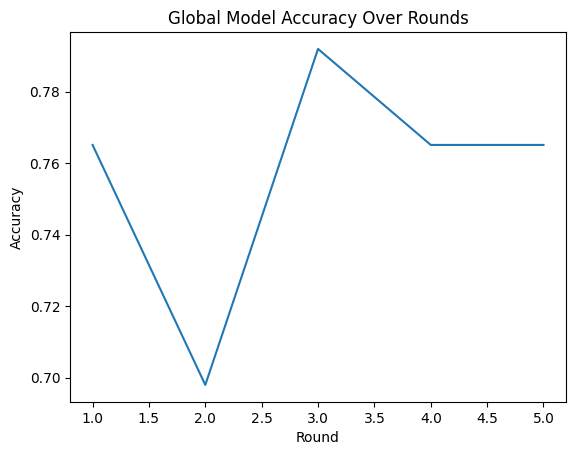

In [ ]:
plt.plot(rounds, accuracies)
plt.title('Global Model Accuracy Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()

#### Save the entire model to a directory

In [ ]:
server_model.save("/content/drive/MyDrive/research/model/model1_10_epoch_densenet121_FedAVG")

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Load the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/research/model/model1_5epoch_densenet121_FedAVG")

In [ ]:
# Function to preprocess an image
def preprocess_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize the image to match the input size used during training
    image = image / 255.0  # Normalize the pixel values (assuming values are in the range [0, 255])
    return image

# Example image file paths (change to your actual file paths)
image_file_positive = "/content/drive/MyDrive/research/dataset/Benign/WBC-Benign-001.jpg"
image_file_negative = "/content/drive/MyDrive/research/dataset/Benign/WBC-Malignant-Early-180.jpg"

# Preprocess the images
image_positive = preprocess_image(image_file_positive)
image_negative = preprocess_image(image_file_negative)

# Make predictions using the loaded model
# You can use a list of images for batch predictions
predictions_positive = loaded_model.predict(np.expand_dims(image_positive, axis=0))
predictions_negative = loaded_model.predict(np.expand_dims(image_negative, axis=0))

# The predictions will be in the form of probabilities
# You can use a threshold to classify them as positive or negative
threshold = 0.5
class_positive = "Malignant" if predictions_positive > threshold else "Benign"
class_negative = "Malignant" if predictions_negative > threshold else "Benign"

print(f"Image 1 (Positive) class: {class_positive} (Probability: {predictions_positive[0][0]})")
print(f"Image 2 (Negative) class: {class_negative} (Probability: {predictions_negative[0][0]})")



1/1 [==============================] - 0s 35ms/step
Image 1 (Positive) class: Malignant (Probability: 0.5420398116111755)
Image 2 (Negative) class: Malignant (Probability: 0.7941195368766785)


In [ ]:
# for update_round in range(update_rounds):
#     global_weights = server_model.get_weights()
#     client_names = list(clients.keys())
#     random.shuffle(client_names)

#     local_models = []

#     for client_name in client_names:
#         data, labels = clients[client_name]
#         local_model = create_densenet_model()
#         local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#         local_model.set_weights(global_weights)

#         local_model.fit(data, labels, epochs=1, batch_size=32)

#         scaling_factor = len(data) / len(X_train)
#         scaled_weights = [w * scaling_factor for w in local_model.get_weights()]
#         local_models.append(scaled_weights)

#         K.clear_session()

#     aggregation_result = federated_averaging(server_model, local_models, [len(data) for data, _ in clients.values()])
#     global_weights = aggregation_result

#     server_model.assign_weights(global_weights)

#     # Evaluate the global model
#     server_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     global_acc = server_model.evaluate(X_test, y_test, verbose=0)[1]

#     # Append accuracy values to the lists
#     rounds.append(update_round + 1)
#     accuracies.append(global_acc)

#     print(f'Update Round: {update_round + 1} | Global Accuracy: {global_acc * 100:.2f}%')
